# Inverse UQ of 'a' and 'm' parameter

In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [2]:
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src, DataFrames, Optim, ForwardDiff, LinearAlgebra, CSV, Plots

## Tools

In [ ]:
"""

"""
function cov_fisher_approx_matrix_am(eval_pt::Vector{Float64}, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=50.0)
    H = ForwardDiff.hessian(x -> compute_ll_am(x, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step, t_obs=t_obs, obs_late=obs_late), eval_pt)
    return inv(-H)
end



"""
    function gen_all_fish_data(M_vals, noise_vals, m, w0, path; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=50.0)

function that generates and stores all the fish data needed. On all a,n0,M,noise prm combinations specifed.

# Arguments
- `M_val::Vector{Int64}`: sample sizes
- `noise_vals::Vector{Float64}`: noise levels
- `m::Float64`: mortality rate in Klausmeier model (fixed)
- `w0::Float64`: initial value for water compartment in Klausmeier model (fixed)
- `path::String`: path to folder where fish data is stored
- `t_fixed::Bool`: true if we consider a fixed observation time window
- `t_end::Float64`: end of observation window (if t_fixed=true)
- `t_step::Float64`: step size with which M observations should be picked (set if t_fixed=false)
"""
function gen_all_fish_data(M_vals, noise_vals, m, w0, path; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=50.0)
    for M in M_vals
        for noise in noise_vals

            grid = Src.create_grid()
            fish = zeros(41, 21)

            # keep track of whether the optimization algo terminates successfully when finding the MLE
            success_counter = 0
            eval_pt_counter = 0

            # evaluate fisher info on grid
            for i in range(1, 41)
                for j in range(1, 21)
                    eval_pt_counter = eval_pt_counter + 1 # total number of optimizations

                    pt = grid[i,j] # true observation parameter point
                    hprm = Src.Hyperprm(w0, pt[2], pt[1], m, M, noise) # w0,n0,a,m,M

                    sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, t_step=t_step, t_obs=t_obs, obs_late=obs_late)
                    sol_true = Src.randomize_data!(sol_true, hprm.noise) # include noise

                    mle, success = compute_mle_am(hprm, sol_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step, t_obs=t_obs, obs_late=obs_late)

                    # evaluate Fi at MLE
                    fish[i,j] = compute_fi_am(mle, hprm, sol_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step, t_obs=t_obs, obs_late=obs_late)

                    success_counter = success_counter + success # number of successfull optimizations
                end
            end

            success_fraction = success_counter / eval_pt_counter
            println("MLE terminated with success in $success_fraction cases.")
            
            # create data frame
            a_eval_pts = string.(0.0:0.1:2.0)
            df_fish = DataFrame(fish, a_eval_pts)

            store_fish_data(w0, m, M, noise, df_fish, path)
        end
    end
end

gen_all_fish_data

## Infer a,m with fisher inversion

we infer a,m for different combinations of observed (a,m,n0) tuples.

In [3]:
# general setup
prm_keys = [:a, :m]
t_fixed = true
t_end = 100.0
obs_late = false;

In [ ]:
path = "C:/Users/lisah/Documents/Repos/ma-code/data/bin/"
noise_vals = [0.0, 0.01]
M_vals = [100]
w0 = 0.95
m = 0.45 # m of data observations is always 0.45

gen_all_fish_data(prm_keys, M_vals, noise_vals, path, t_fixed=t_fixed, t_end=t_end)

Plots are analyzed in "notebooks\playground\infer_am\plots_inverse_uq_am.ipynb".

We analyze the identifiability of the following points:
1. a = 0.3, m = 0.45, n0 = 1.5
2. a = 0.9, m = 0.45, n0 = 1.5
3. a = 1.5, m = 0.45, n0 = 1.5

## Generate likelihood data at points

In [6]:
# set global parameters
m_true = 0.45
n0_true = 1.5
w0 = 0.95;

In [7]:
points = [[0.3,0.45]]
M_vals = [1000]
noise_vals = [0.0, 0.01]
path = "C:/Users/lisah/Documents/Repos/ma-code/data/bin/"

gen_all_ll_data(points, prm_keys, M_vals, noise_vals, path, t_fixed=t_fixed, t_end=t_end)

## Practical identifiability

In [104]:
t_fixed = true
t_end = 200.0
obs_late = true
t_obs = 100.0;

In [206]:
# set global parameters
m_true = 0.45
n0_true = 1.5
w0 = 0.95
M = 100
noise = 0.1;

### Tools

In [207]:
function plot_mult_restart_mles(inits::Vector, mles::Vector, ind_best::Int64, prm_name::String; compare::Bool=true)
    N = length(mles)
    plot(mles, label="MLEs", title="Multiple restart MLE of $prm_name",color=:orange, ylabel="parameter value", xlabel="restart index")
    if prm_name == "a"
        hline!([hprm.a], linestyle=:dash, linewidth=2, color=:black,  label="true parameter")
    else 
        hline!([hprm.m], linestyle=:dash, linewidth=2, color=:black,  label="true parameter")
    end
    scatter!(1:N, mles, markershape=:square, markersize=2, color=:orange, label="")

    if compare
        plot!(inits, label="inits", color=:blue)
        scatter!(1:N, inits, markershape=:square, markersize=2, color=:blue, label="")
    end
    scatter!([best_loss_ind], [mles[best_loss_ind]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="best estimate")
end

function plot_mult_restart_losses(inits_loss::Vector, losses::Vector, ind_best::Int64; compare::Bool=true)
    N = length(losses)
    plot(losses, label="MLEs", color=:darkorange, title="Loss evolution of multiple restart MLE", ylabel = "loss value", xlabel="restart index")
    scatter!(1:N, losses, markershape=:square, markersize=2, color=:darkorange, label="")

    if compare
        plot!(inits_loss, label="init", color=:blue)
        scatter!(1:N, inits_loss, markershape=:square, markersize=2, color=:blue, label="")
    end

    scatter!([best_loss_ind], [losses[best_loss_ind]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="lowest")
end

function correlation_matrix(eval_pt::Vector{Float64}, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, obs_late::Bool=false, t_obs::Float64=50.0)
    fim = - ForwardDiff.hessian(x -> compute_ll_am(x, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step, obs_late=obs_late, t_obs=t_obs), eval_pt)
    cov = inv(fim)
    cor = [cov[i,j] / sqrt(cov[i,i]*cov[j,j]) for i in range(1, size(cov,1)), j in range(1, size(cov,2))]
    return cor
end

correlation_matrix (generic function with 1 method)

### 1. Left of bifurcation point

In [208]:
a_true = 0.3
hprm = Src.Hyperprm(w0, n0_true, a_true, m_true, M, noise)

# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy

#### Multiple restart optim

In [209]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = mult_restart_mle_am(N, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs);

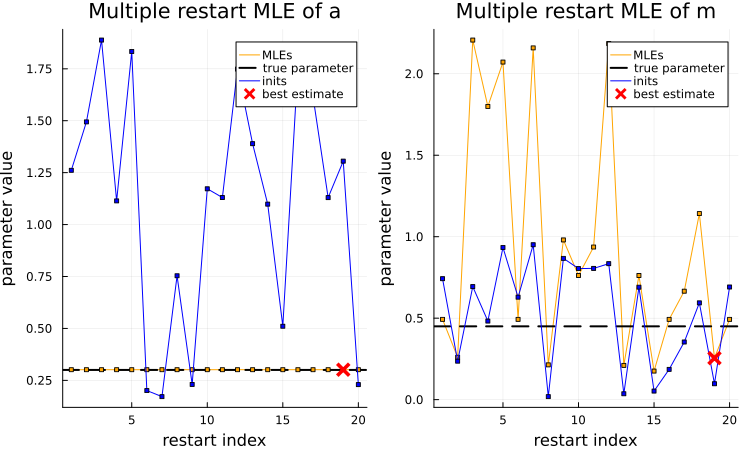

In [210]:
# plot inits vs. mles
plot_a = plot_mult_restart_mles(inits[:,1], mles[:,1], best_loss_ind,"a")
plot_m = plot_mult_restart_mles(inits[:,2], mles[:,2], best_loss_ind,"m")
plot(plot_a, plot_m,layout=(1,2), size=(750,450))

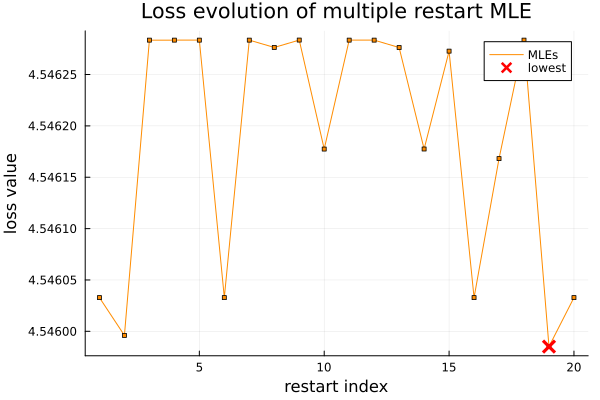

In [211]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

#### Correlation matrix of MLEs

In [212]:
mle_pt = mles[best_loss_ind,:]

2-element Vector{Float64}:
 0.30122819001565765
 0.25483132804161734

In [213]:
correlation_matrix(mle_pt, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs)

2×2 Matrix{Float64}:
 1.0         6.09813e-6
 6.09813e-6  1.0

In [214]:
cov_fisher_approx_matrix_am(mle_pt, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs)

2×2 Matrix{Float64}:
 0.002        0.000184376
 0.000184376  4.57073e5

### 2. At bifurcation point

In [215]:
a_true = 0.9
hprm = Src.Hyperprm(w0, n0_true, a_true, m_true, M, noise)

# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy

#### Multiple restart optim

In [216]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = mult_restart_mle_am(N, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs);

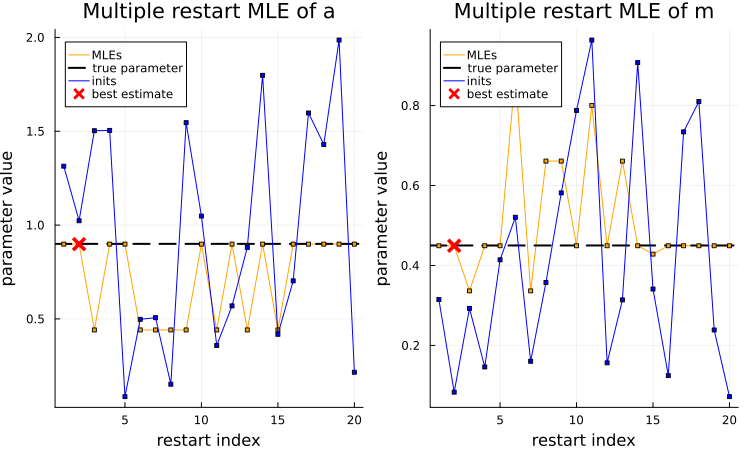

In [217]:
# plot inits vs. mles
plot_a = plot_mult_restart_mles(inits[:,1], mles[:,1], best_loss_ind,"a")
plot_m = plot_mult_restart_mles(inits[:,2], mles[:,2], best_loss_ind,"m")
plot(plot_a, plot_m,layout=(1,2), size=(750,450))

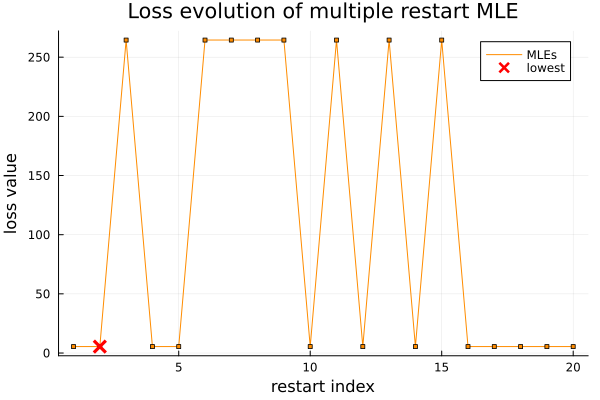

In [218]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

#### Correlation matrix of MLEs

In [219]:
mle_pt = mles[best_loss_ind,:]


2-element Vector{Float64}:
 0.898471181722768
 0.44930968346509526

In [220]:
correlation_matrix(mle_pt, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs)

2×2 Matrix{Float64}:
 1.0      0.99994
 0.99994  1.0

### 3. Right of bifurcation point

In [221]:
a_true = 1.5
hprm = Src.Hyperprm(w0, n0_true, a_true, m_true, M, noise)

# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy

#### Multiple restart optim

In [222]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = mult_restart_mle_am(N, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs);

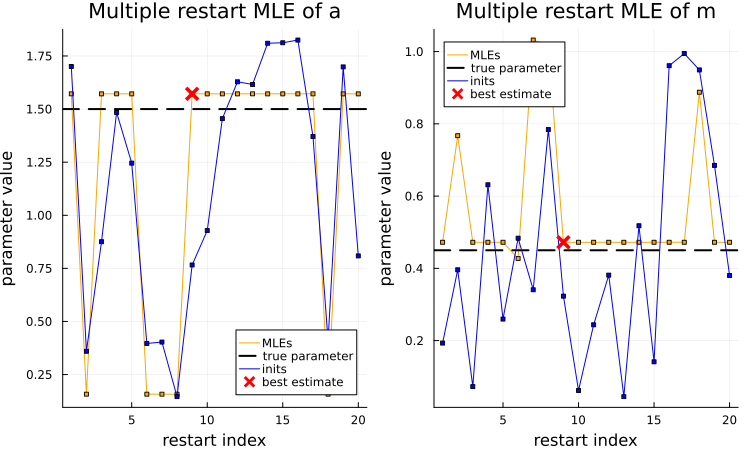

In [223]:
# plot inits vs. mles
plot_a = plot_mult_restart_mles(inits[:,1], mles[:,1], best_loss_ind,"a")
plot_m = plot_mult_restart_mles(inits[:,2], mles[:,2], best_loss_ind,"m")
plot(plot_a, plot_m,layout=(1,2), size=(750,450))

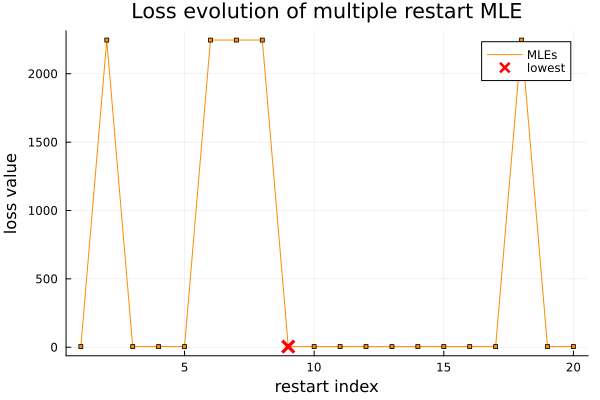

In [224]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

#### Correlation matrix of MLEs

In [225]:
mle_pt = mles[best_loss_ind,:]


2-element Vector{Float64}:
 1.571722487954246
 0.47218601497336776

In [226]:
correlation_matrix(mle_pt, hprm, sol_true, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late, t_obs=t_obs)

2×2 Matrix{Float64}:
 1.0       0.999124
 0.999124  1.0